In [289]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import xgboost
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix, make_scorer, recall_score, precision_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [242]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [243]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [244]:
X_train.head()
len(X_train)

49000

DO WYRZUCENIA

In [245]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [246]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [247]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [248]:
# HighCorrelationRemover with preserved feature names
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [249]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

In [ ]:
X_train_transformed_df = X_train_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
X_test_transformed_df = X_test_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))

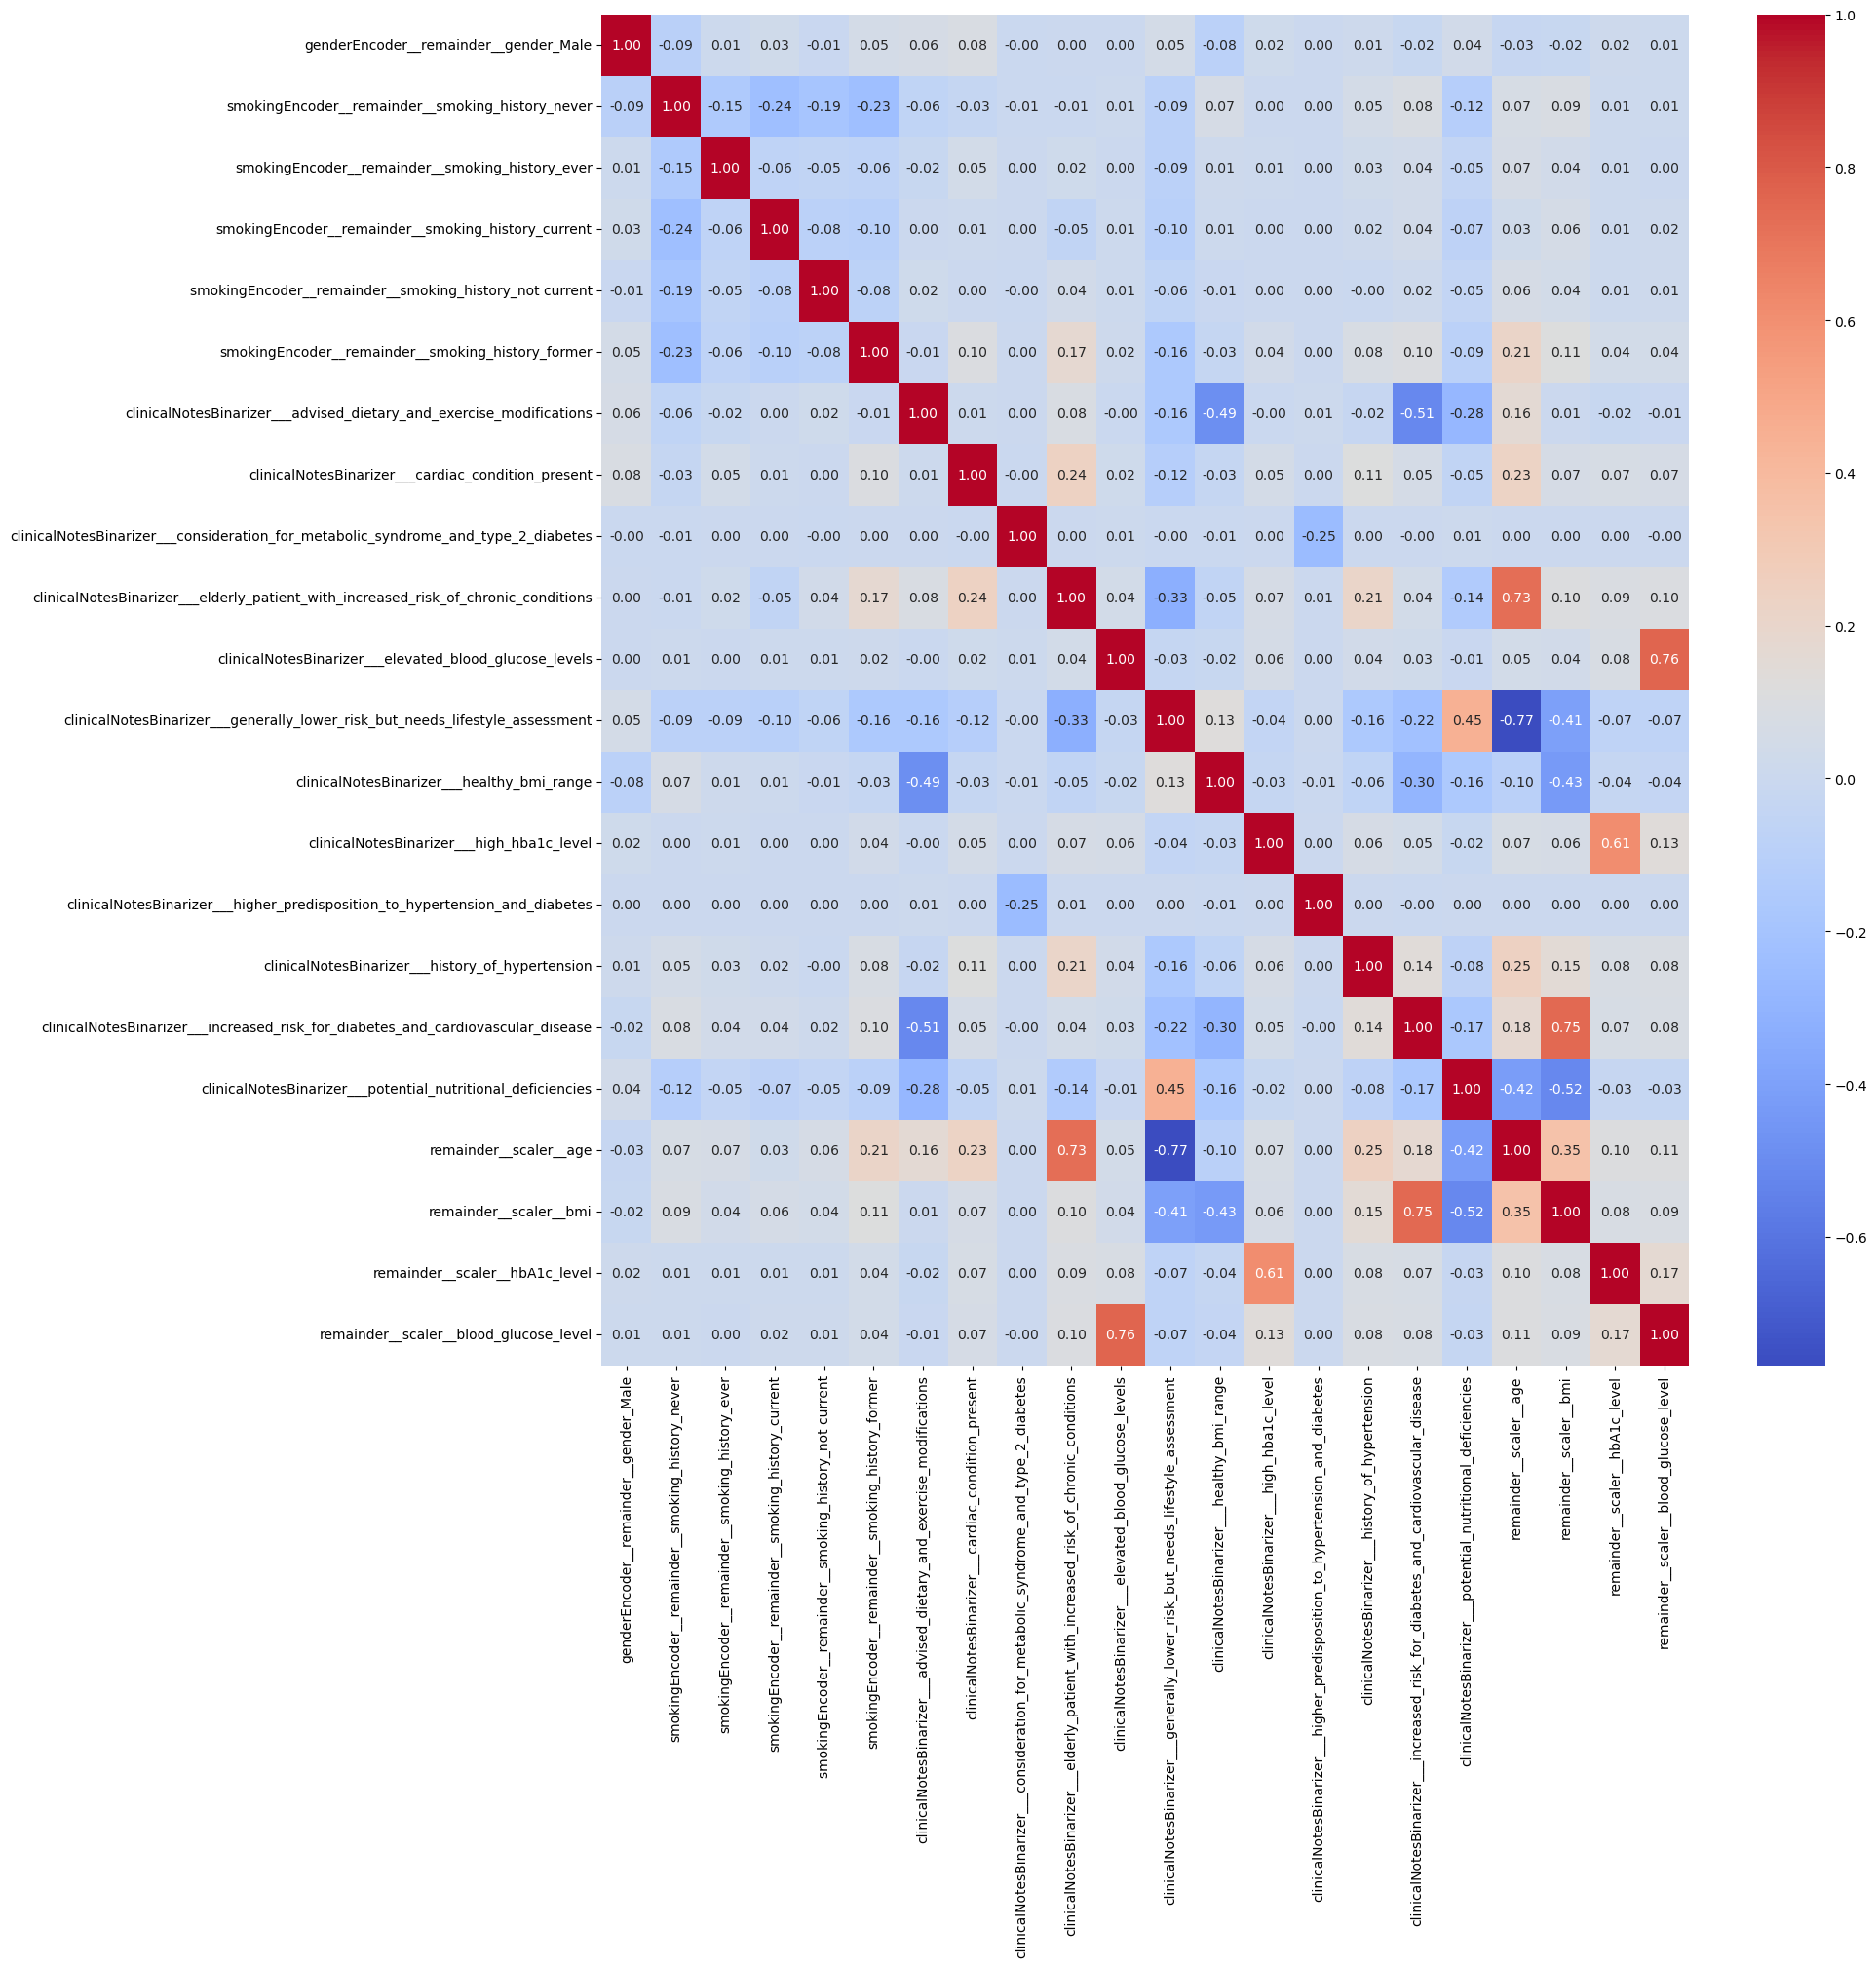

In [296]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [251]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    # Predictions and probabilities
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]  # Probabilities for training
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1]   # Probabilities for test
    
    # Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    # Evaluate the model
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  # PR-AUC for training
    test_pr_auc = auc(recall_test, precision_test)     # PR-AUC for test
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    
    # Print results
    print("\nModel Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc)


Model Performance:
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training Accuracy Score: 0.9616
Test Accuracy Score: 0.9619
Training Recall Score: 0.6291
Test Recall Score: 0.6336
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


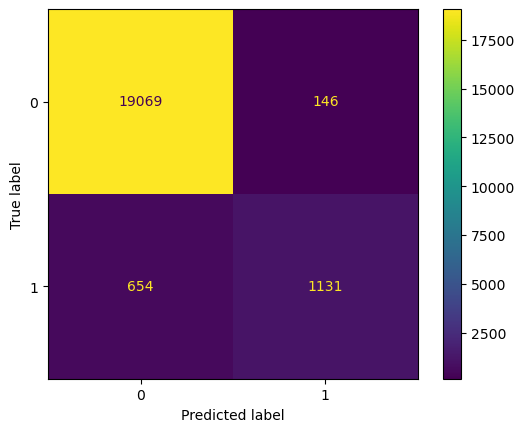

(0.810778737724598, 0.8130076074145506, 0.8254827428707748, 0.8309939154416266)

In [252]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


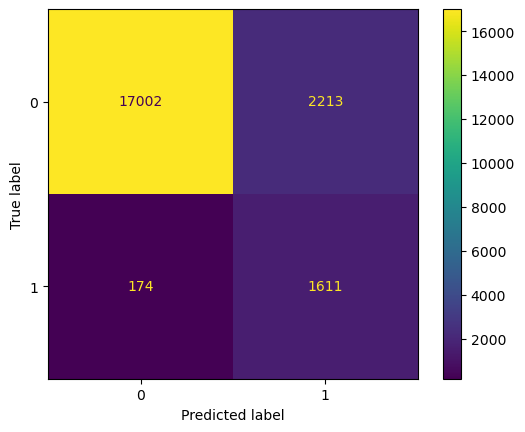

(0.8891248302599728,
 0.8936752843213788,
 0.8233054034123571,
 0.8289386583993921)

In [253]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

In [254]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']



Model Performance:
Training ROC-AUC: 0.8870
Test ROC-AUC: 0.8908
Training PR-AUC: 0.8199
Test PR-AUC: 0.8273
Training Accuracy Score: 0.8862
Test Accuracy Score: 0.8843
Training Recall Score: 0.8879
Test Recall Score: 0.8986
Test Confusion Matrix:
 [[16967  2248]
 [  181  1604]]


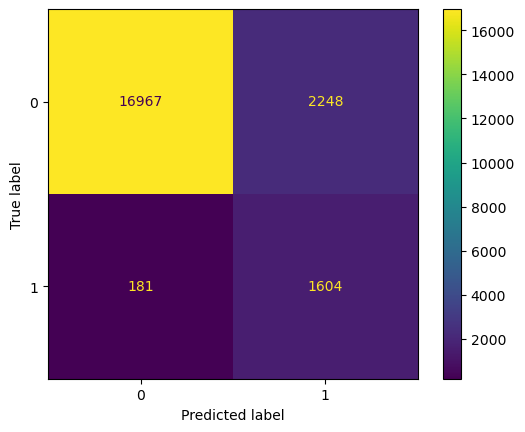

(0.8869843019174884, 0.8908037531952671, 0.8198885197689099, 0.827260161369482)

In [255]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training ROC-AUC: 0.8888
Test ROC-AUC: 0.8935
Training PR-AUC: 0.8233
Test PR-AUC: 0.8290
Training Accuracy Score: 0.8874
Test Accuracy Score: 0.8861
Training Recall Score: 0.8905
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[16997  2218]
 [  174  1611]]


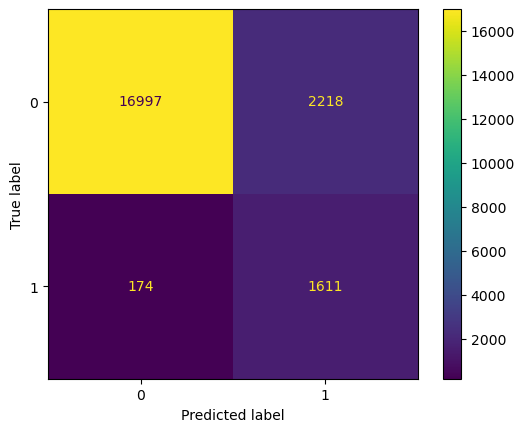

(0.8888066702090672, 0.893545177633895, 0.8233377305854888, 0.8289891805488439)

In [256]:
model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training ROC-AUC: 0.8886
Test ROC-AUC: 0.8933
Training PR-AUC: 0.8236
Test PR-AUC: 0.8294
Training Accuracy Score: 0.8878
Test Accuracy Score: 0.8861
Training Recall Score: 0.8896
Test Recall Score: 0.9020
Test Confusion Matrix:
 [[16999  2216]
 [  175  1610]]


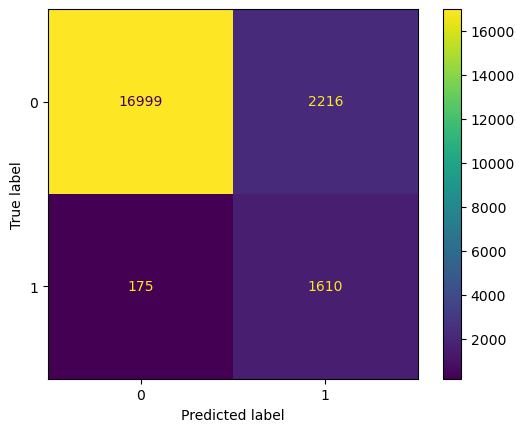

(0.8885718221714917,
 0.8933171082640706,
 0.8235557633566688,
 0.8293514363959009)

In [257]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)


Model Performance:
Training ROC-AUC: 0.8831
Test ROC-AUC: 0.8878
Training PR-AUC: 0.8148
Test PR-AUC: 0.8214
Training Accuracy Score: 0.8807
Test Accuracy Score: 0.8803
Training Recall Score: 0.8860
Test Recall Score: 0.8969
Test Confusion Matrix:
 [[16885  2330]
 [  184  1601]]


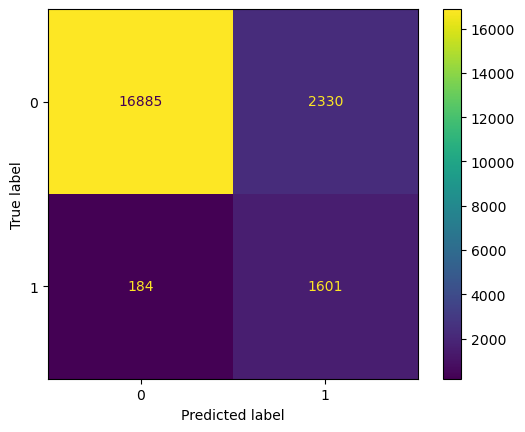

(0.883068637290982, 0.88782966738608, 0.8148046887663917, 0.8214140922381276)

In [258]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


The results with Variance Treshold are worse than only Logistic Regression


Model Performance:
Training ROC-AUC: 0.8038
Test ROC-AUC: 0.7892
Training PR-AUC: 0.8892
Test PR-AUC: 0.7988
Training Accuracy Score: 0.9642
Test Accuracy Score: 0.9597
Training Recall Score: 0.6106
Test Recall Score: 0.5838
Test Confusion Matrix:
 [[19112   103]
 [  743  1042]]


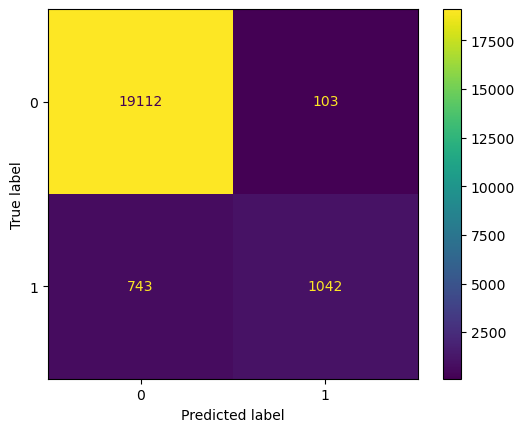

(0.8038323526131764,
 0.7891965529381152,
 0.8892429213467883,
 0.7987520894198481)

In [259]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

RandomisedSearchCV for DecisionTreeClassifier

Best parameters: {'min_samples_split': 3, 'min_samples_leaf': 0.05, 'max_features': 9, 'max_depth': 12, 'criterion': 'gini'}

Best model scores:

Model Performance:
Training ROC-AUC: 0.7974
Test ROC-AUC: 0.7998
Training PR-AUC: 0.4360
Test PR-AUC: 0.4223
Training Accuracy Score: 0.7656
Test Accuracy Score: 0.7666
Training Recall Score: 0.8358
Test Recall Score: 0.8398
Test Confusion Matrix:
 [[14599  4616]
 [  286  1499]]


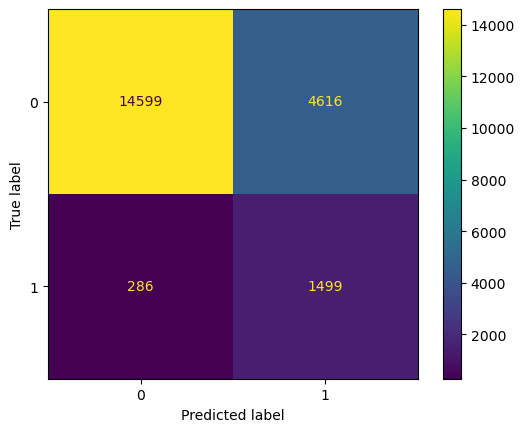

(0.7974455355912856,
 0.7997734612970872,
 0.43601899324189636,
 0.42227782512733075)

In [260]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    "max_depth" : range(2, 20),
    "max_features" : range(2, 10),
    "min_samples_split" : range(2, 20),
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(class_weight='balanced')
scoring = {
    'roc_auc': 'roc_auc', 
    'f1_score': 'f1',  
    'pr_auc': make_scorer(pr_auc_scorer),
    'recall': 'recall' 
}

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='recall')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


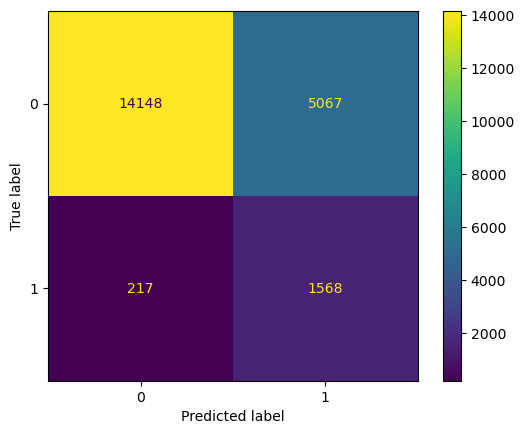

In [261]:
lr = LogisticRegression(class_weight='balanced')

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, dt)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Voting Classifier

Logistic Regression

Model Performance:
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


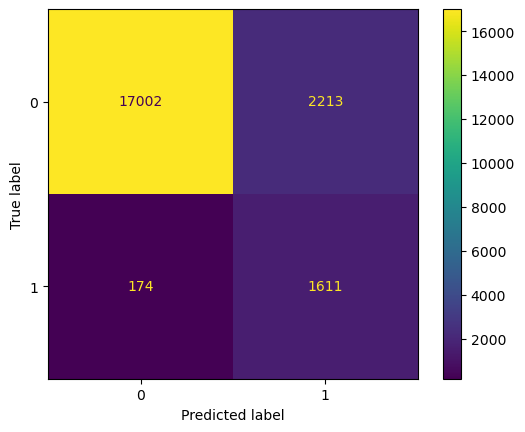

K Nearest Neighbours

Model Performance:
Training ROC-AUC: 0.7941
Test ROC-AUC: 0.7840
Training PR-AUC: 0.8813
Test PR-AUC: 0.8023
Training Accuracy Score: 0.9632
Test Accuracy Score: 0.9600
Training Recall Score: 0.5904
Test Recall Score: 0.5720
Test Confusion Matrix:
 [[19140    75]
 [  764  1021]]


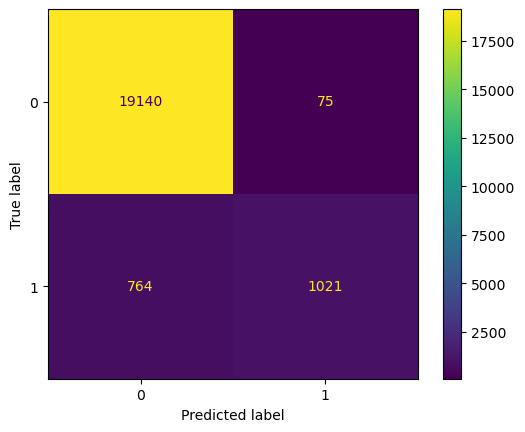

Classification Tree

Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


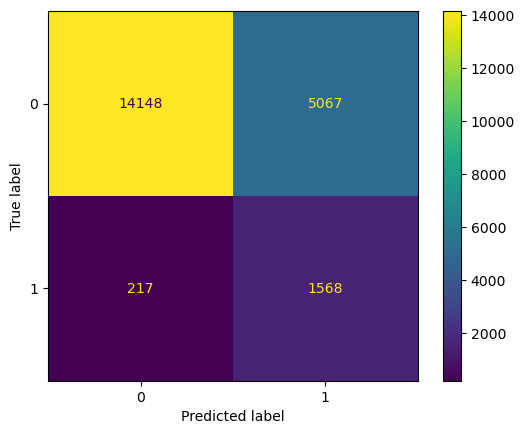

Voting classifier:

Model Performance:
Training ROC-AUC: 0.8914
Test ROC-AUC: 0.8812
Training PR-AUC: 0.8488
Test PR-AUC: 0.8250
Training Accuracy Score: 0.9312
Test Accuracy Score: 0.9282
Training Recall Score: 0.8435
Test Recall Score: 0.8246
Test Confusion Matrix:
 [[18020  1195]
 [  313  1472]]


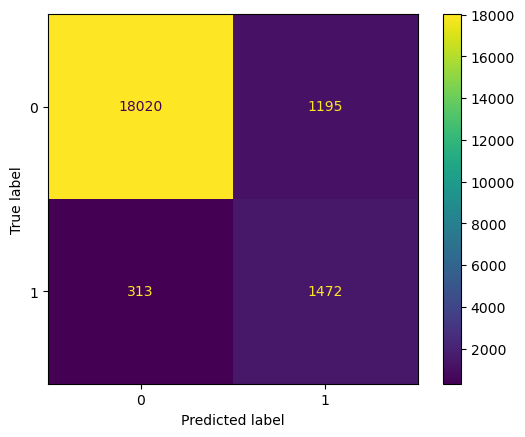

(0.8913840946214552,
 0.8812294316633756,
 0.8488106928380809,
 0.8249784431182627)

In [262]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
print('Voting classifier:')
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

Random Forest Classifier


Model Performance:
Training ROC-AUC: 0.9358
Test ROC-AUC: 0.9022
Training PR-AUC: 0.9281
Test PR-AUC: 0.8783
Training Accuracy Score: 0.9332
Test Accuracy Score: 0.9238
Training Recall Score: 0.9390
Test Recall Score: 0.8762
Test Confusion Matrix:
 [[17836  1379]
 [  221  1564]]


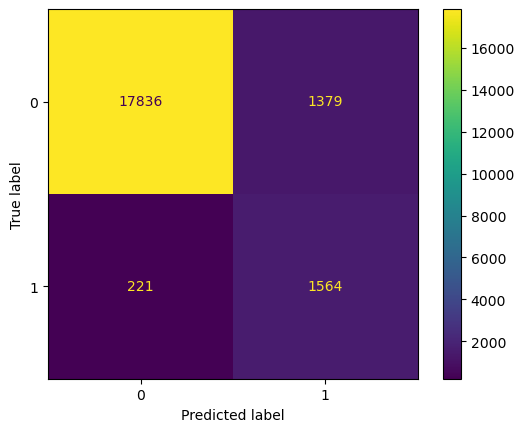

(0.9358399097343856, 0.9022118136872236, 0.928109732501218, 0.8782856918962457)

In [263]:
rf = RandomForestClassifier(max_depth=13, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training ROC-AUC: 0.9348
Test ROC-AUC: 0.8994
Training PR-AUC: 0.9262
Test PR-AUC: 0.8768
Training Accuracy Score: 0.9324
Test Accuracy Score: 0.9219
Training Recall Score: 0.9378
Test Recall Score: 0.8723
Test Confusion Matrix:
 [[17803  1412]
 [  228  1557]]


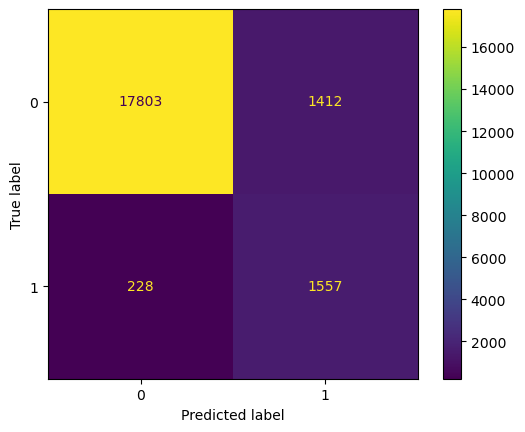

(0.9348493495758959, 0.8993923252361053, 0.9261968895377567, 0.876849671350519)

In [264]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9404
Test ROC-AUC: 0.9032
Training PR-AUC: 0.9307
Test PR-AUC: 0.8788
Training Accuracy Score: 0.9381
Test Accuracy Score: 0.9271
Training Recall Score: 0.9431
Test Recall Score: 0.8745
Test Confusion Matrix:
 [[17908  1307]
 [  224  1561]]


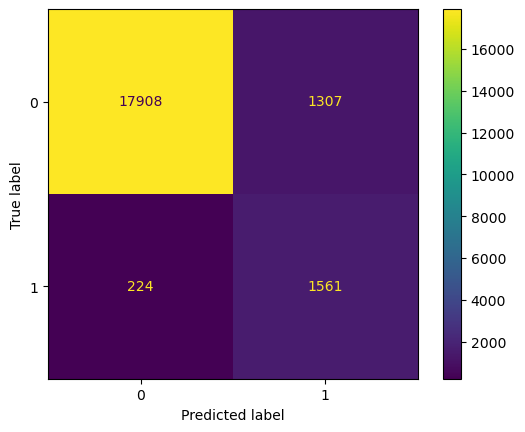

(0.9403676224588196,
 0.9032450138525355,
 0.9306874208438739,
 0.8787746205902209)

In [265]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9366
Test ROC-AUC: 0.9017
Training PR-AUC: 0.9298
Test PR-AUC: 0.8796
Training Accuracy Score: 0.9350
Test Accuracy Score: 0.9243
Training Recall Score: 0.9385
Test Recall Score: 0.8745
Test Confusion Matrix:
 [[17849  1366]
 [  224  1561]]


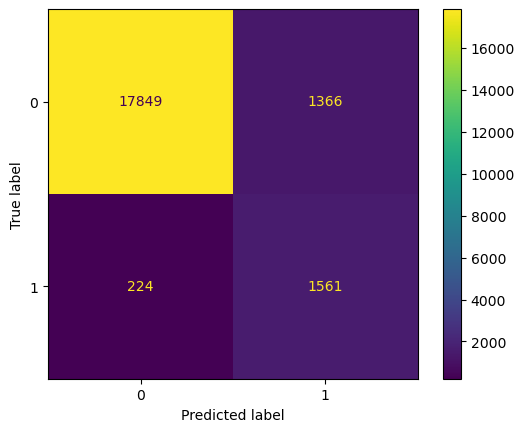

[0.00504734 0.00346446 0.00224065 0.00299685 0.00256093 0.0041474
 0.00372462 0.0085724  0.0035     0.03976527 0.06325922 0.03020052
 0.00563677 0.08144915 0.00326495 0.0164745  0.02077159 0.00337901
 0.11644539 0.05354776 0.29345289 0.23609831]

Model Performance:
Training ROC-AUC: 0.9223
Test ROC-AUC: 0.8924
Training PR-AUC: 0.8932
Test PR-AUC: 0.8593
Training Accuracy Score: 0.9106
Test Accuracy Score: 0.9011
Training Recall Score: 0.9364
Test Recall Score: 0.8818
Test Confusion Matrix:
 [[17350  1865]
 [  211  1574]]


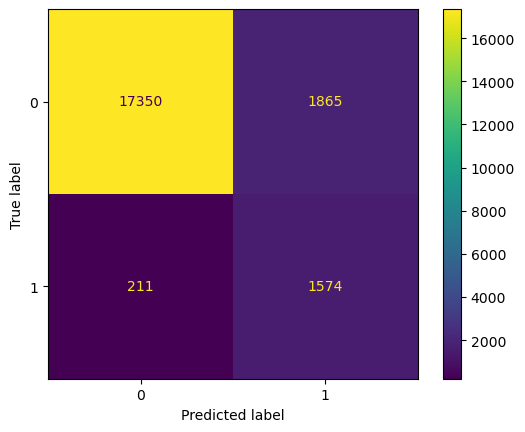

(0.9222744835639174,
 0.8923665641119835,
 0.8932295173757647,
 0.8592572334254305)

In [266]:
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)

Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.

Model Performance:
Training ROC-AUC: 0.9419
Test ROC-AUC: 0.9019
Training PR-AUC: 0.9328
Test PR-AUC: 0.8772
Training Accuracy Score: 0.9406
Test Accuracy Score: 0.9283
Training Recall Score: 0.9436
Test Recall Score: 0.8700
Test Confusion Matrix:
 [[17942  1273]
 [  232  1553]]


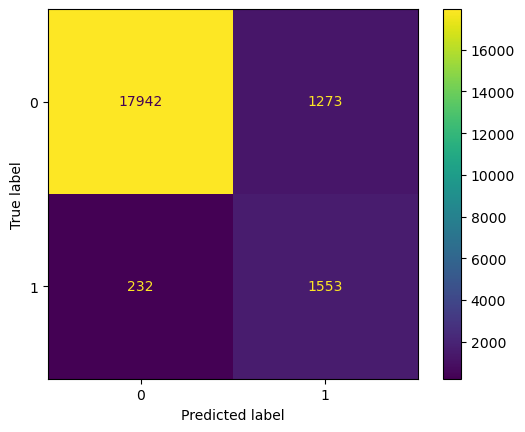

(0.9419236547077848,
 0.9018888429688815,
 0.9327700879285412,
 0.8772120832259092)

In [267]:
rfe = RFE(estimator=rf, n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

[0.26026325 0.43996261 0.5796008  0.70175682 0.75437267 0.79355488
 0.82689059 0.85720648 0.87952059 0.89768802 0.91357461 0.92823281
 0.94141713 0.9541003  0.96523757 0.97465769 0.98210941 0.98733193
 0.99207206 0.99633129 1.         1.        ]


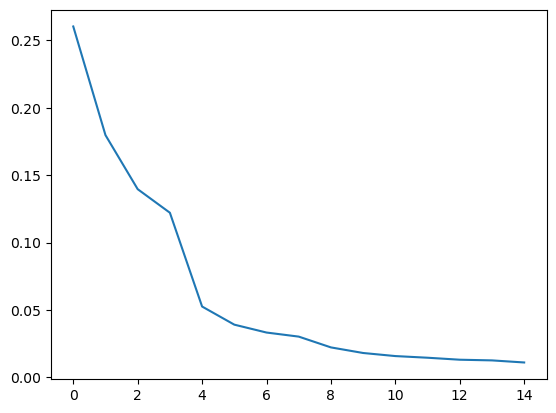

In [268]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', rf)
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)


Model Performance:
Training ROC-AUC: 0.9543
Test ROC-AUC: 0.8893
Training PR-AUC: 0.9378
Test PR-AUC: 0.8581
Training Accuracy Score: 0.9543
Test Accuracy Score: 0.9359
Training Recall Score: 0.9541
Test Recall Score: 0.8331
Test Confusion Matrix:
 [[18167  1048]
 [  298  1487]]


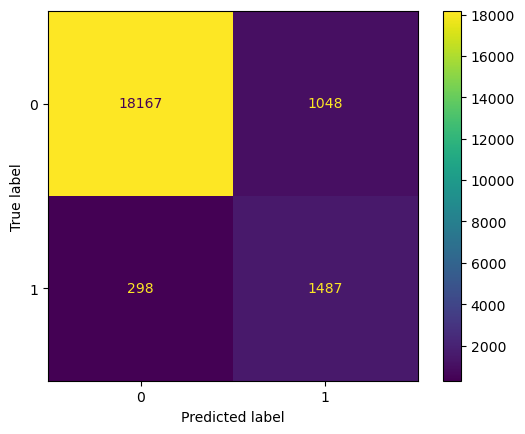

(0.9542538326806131,
 0.8892562489476665,
 0.9377756628101327,
 0.8580622353692324)

In [269]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5)),
    ('classifier', rf)
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)

Here the best model for now: (I guess?)

Best parameters: {'n_estimators': 52, 'min_samples_split': 12, 'max_features': 6, 'max_depth': 9}

Best model scores:

Model Performance:
Training ROC-AUC: 0.9095
Test ROC-AUC: 0.9078
Training PR-AUC: 0.8831
Test PR-AUC: 0.8836
Training Accuracy Score: 0.8925
Test Accuracy Score: 0.8922
Training Recall Score: 0.9299
Test Recall Score: 0.9266
Test Confusion Matrix:
 [[17082  2133]
 [  131  1654]]


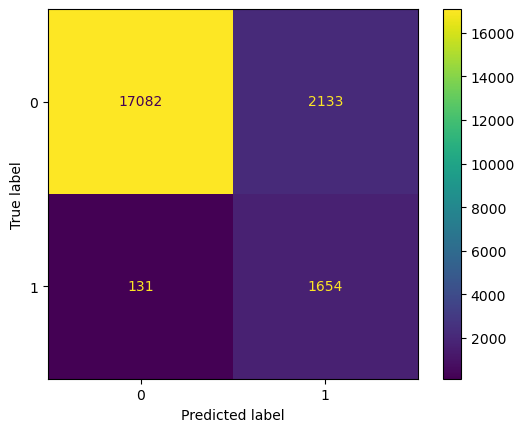

(0.9094759215161474,
 0.9078018092482896,
 0.8831159900461423,
 0.8835856297956199)

In [270]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : range(2, 10),
              "min_samples_split" : range(2, 20),
              "n_estimators" : range(2, 100, 10)}

scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.9089
Test ROC-AUC: 0.9088
Training PR-AUC: 0.8839
Test PR-AUC: 0.8846
Training Accuracy Score: 0.8989
Test Accuracy Score: 0.8986
Training Recall Score: 0.9210
Test Recall Score: 0.9210
Test Confusion Matrix:
 [[17227  1988]
 [  141  1644]]


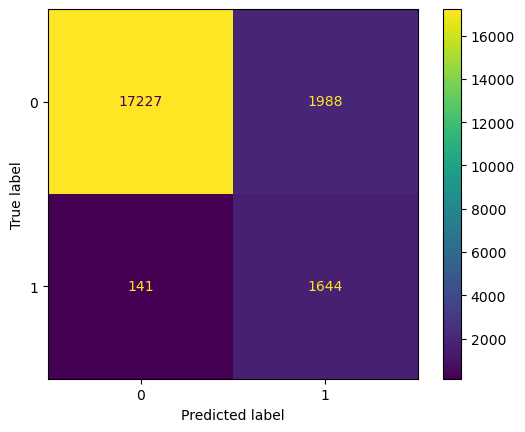

(0.9089484974317594,
 0.9087737827371385,
 0.8838717873607116,
 0.8846308247256833)

In [271]:
clf = BaggingClassifier(estimator=best_model,
                        n_estimators=15)
scores_model(X_train_transformed_df, X_test_transformed_df, clf)


Model Performance:
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8679
Test PR-AUC: 0.8773
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Training Recall Score: 0.6639
Test Recall Score: 0.6930
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


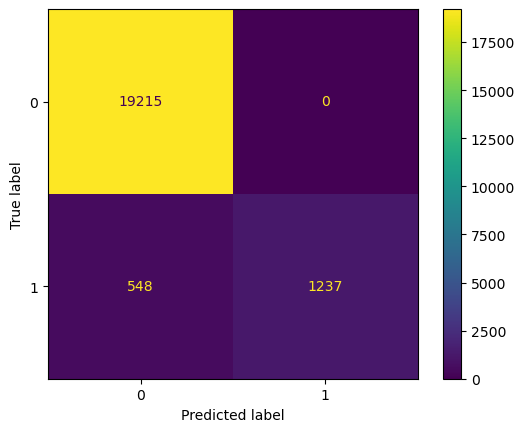

(0.8319327731092436,
 0.8464985994397759,
 0.8679404059139555,
 0.8773173872150284)

In [272]:
ada = AdaBoostClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, ada)

GBoost


Model Performance:
Training ROC-AUC: 0.9169
Test ROC-AUC: 0.9129
Training PR-AUC: 0.8870
Test PR-AUC: 0.8872
Training Accuracy Score: 0.9007
Test Accuracy Score: 0.9007
Training Recall Score: 0.9364
Test Recall Score: 0.9277
Test Confusion Matrix:
 [[17258  1957]
 [  129  1656]]


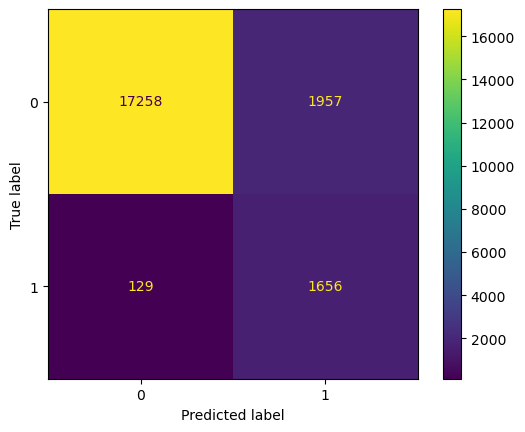

Best parameters: {'min_samples_leaf': 10, 'max_features': 0.4, 'max_depth': 9}

Best model scores:

Model Performance:
Training ROC-AUC: 0.9082
Test ROC-AUC: 0.9075
Training PR-AUC: 0.8821
Test PR-AUC: 0.8868
Training Accuracy Score: 0.8882
Test Accuracy Score: 0.8870
Training Recall Score: 0.9323
Test Recall Score: 0.9322
Test Confusion Matrix:
 [[16964  2251]
 [  121  1664]]


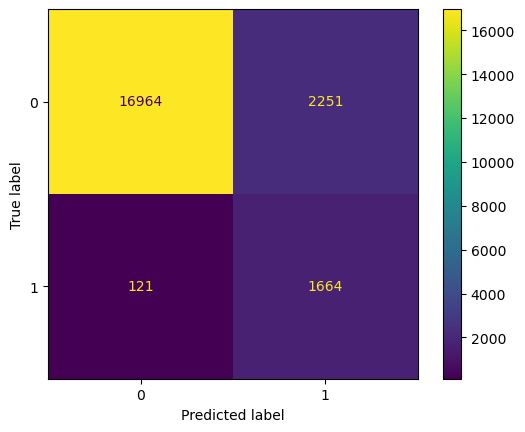

(0.9082006573121052, 0.9075324118718525, 0.882112978194153, 0.8867521493773)

In [ ]:
gboost = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, gboost)

# jak dla mnie lepiej działa ten pierwszy i ten search można usunąć

param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20)}

scorer = make_scorer(recall_score)

random_search_boost = RandomizedSearchCV(estimator=gboost, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search_boost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_boost.best_params_)

best_model_boost = random_search_boost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model_boost)

XGBoost


Model Performance:
Training ROC-AUC: 0.9868
Test ROC-AUC: 0.8800
Training PR-AUC: 0.9932
Test PR-AUC: 0.8645
Training Accuracy Score: 0.9781
Test Accuracy Score: 0.9440
Training Recall Score: 0.9974
Test Recall Score: 0.8028
Test Confusion Matrix:
 [[18391   824]
 [  352  1433]]


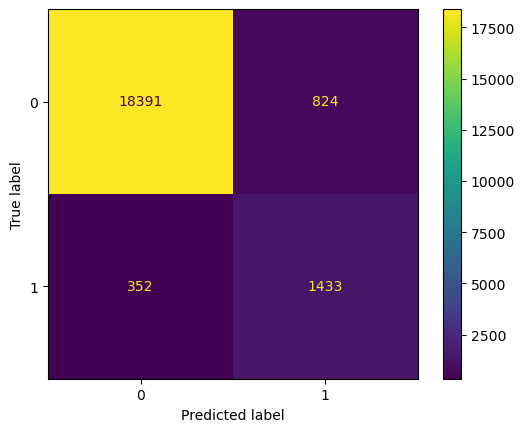


Model Performance:
Training ROC-AUC: 0.8622
Test ROC-AUC: 0.8644
Training PR-AUC: 0.7618
Test PR-AUC: 0.7645
Training Accuracy Score: 0.8152
Test Accuracy Score: 0.8137
Training Recall Score: 0.9188
Test Recall Score: 0.9255
Test Confusion Matrix:
 [[15436  3779]
 [  133  1652]]


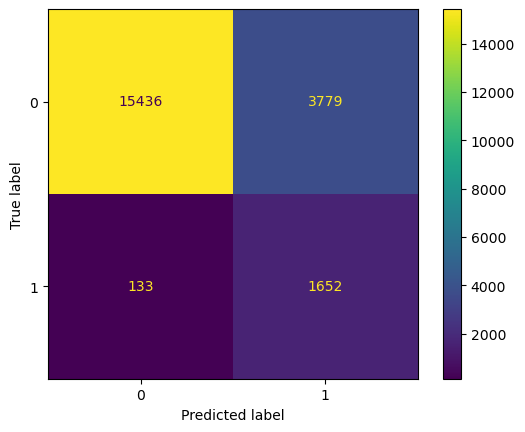

(0.8622117699538834,
 0.8644104636390075,
 0.7618036340491089,
 0.7645115574793755)

In [301]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gbtree',
                    max_depth=20,
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb)

xgb=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gblinear',
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb)

Best parameters: {'n_estimators': 130, 'min_child_weight': 9, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

Best model scores:

Model Performance:
Training ROC-AUC: 0.9096
Test ROC-AUC: 0.9070
Training PR-AUC: 0.8821
Test PR-AUC: 0.8848
Training Accuracy Score: 0.8883
Test Accuracy Score: 0.8874
Training Recall Score: 0.9352
Test Recall Score: 0.9305
Test Confusion Matrix:
 [[16974  2241]
 [  124  1661]]


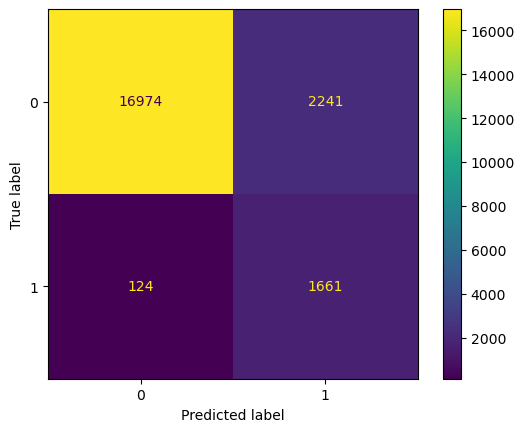

(0.9095520175283227,
 0.9069522891123663,
 0.8820863153928384,
 0.8848248513762562)

In [302]:
xgb=XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight)

param_dist = {
    "max_depth": range(2, 20),
    "min_child_weight": range(1, 10),
    "n_estimators": range(10, 200, 10), 
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "booster": ["gbtree", "gblinear"]
}

random_search_xgboost = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search_xgboost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_xgboost.best_params_)

best_model_xgboost = random_search_xgboost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model_xgboost)